<a href="https://colab.research.google.com/github/sbc806/cpsc_533y_project/blob/master/run_nlgat_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/sbc806/cpsc_533y_project.git

Cloning into 'cpsc_533y_project'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 53 (delta 18), reused 14 (delta 4), pack-reused 10
Receiving objects: 100% (53/53), 282.43 KiB | 1.66 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [3]:
import sys as sys

sys.path.append("/content/cpsc_533y_project")

In [4]:
import sys as sys

sys.path.append("/content/cpsc_533y_project/nlgat")

Read in data

In [5]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.2
    Uninstalling nbformat-5.9.2:
      Successfully uninstalled n

# Get configuration

In [6]:
!pip install ml_collections==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94505 sha256=9caed5a601bee86252885700476297d8f984a8f6dd8f796a5e8df6e666a49dea
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml_collections


In [7]:
import ml_collections

In [8]:
def get_config():
    config = ml_collections.ConfigDict()

    config.mode = "train"

    # Hyperparameters for dataset.
    config.num_pts = 64
    config.num_classes = 40
    config.use_voxel = False
    config.rot_type = "SO3"
    config.rot = False
    config.normalize = True
    config.center = False
    config.preprocess = False

    # Hyperparameters for models.

    # Hyperparameters for GSN
    config.gsn_init = None

    # Hyperparameters for GRN
    # Localize each local Gram matrix
    config.localize = True
    # For sorting the rows of the Gram matrix
    # Can sort rows in ascending or descending order
    config.descending = False
    # For converting MxMxN tensor to MxN tensor
    # Can be average, absolute_average or maximum
    config.reduce_option = "average"

    # Hyperparameters for training.
    config.log_dir = "logs"
    config.use_cuda = True
    config.batch_size = 32
    config.num_epochs = 200
    config.lr = 0.02
    config.weight_decay = 0.0
    config.label_smoothing = 0.20

    # Hyperparameters for ablation study
    config.mode = "both"
    return config

In [9]:
config = get_config()

In [10]:
config

batch_size: 32
center: false
descending: false
gsn_init: null
label_smoothing: 0.2
localize: true
log_dir: logs
lr: 0.02
mode: both
normalize: true
num_classes: 40
num_epochs: 200
num_pts: 64
preprocess: false
reduce_option: average
rot: false
rot_type: SO3
use_cuda: true
use_voxel: false
weight_decay: 0.0

# Get dataloaders

In [11]:
# From ScanObjectNN GitHub
def normalize_data(pcs):
    for pc in pcs:
        d = max(np.sum(np.abs(pc)**2, axis=-1)**(1./2))
        # print(d)
        pc /= d
    return pcs

In [12]:
# From ScanObjectNN GitHub
def center_data(pcs):
    for pc in pcs:
        centroid = np.mean(pc, axis=0)
        pc[:0]-=centroid[0]
        pc[:,1]-=centroid[1]
        pc[:,2]-=centroid[2]
        # print(centroid)
    return pcs

In [13]:
from torch.utils.data import Subset
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import torch.nn.functional as F

import time
import numpy as np

In [14]:
# Make any adjustments to the data configuration
config.num_pts=256

In [15]:
config.rot=True

## ModelNet40

## Copy data from original directory to /cpsc_533y_project/data

In [16]:
!cp -r /content/drive/MyDrive/cpsc_533y/project_datasets/modelnet40_ply_hdf5_2048 /content/cpsc_533y_project/data

In [17]:
from dataloader import load_data, ModelNetDataLoader

print(config)

# Adjust path to the folder modelnet40_ply_hdf5_2048 as needed
datapath = "/content/cpsc_533y_project/data/modelnet40_ply_hdf5_2048/"
n_points = config.num_pts
use_voxel = config.use_voxel
rot_type = config.rot_type
rot = config.rot

train_data, train_label, test_data, test_label = load_data(datapath, classification=True)
if config.normalize:
    print("Normalizing training data")
    train_data = normalize_data(train_data)
if config.center:
    print("Centering training data")
    train_data = center_data(train_data)
if config.normalize:
    print("Normalizing test data")
    test_data = normalize_data(test_data)
if config.center:
    print("Centering test data")
    test_data = center_data(test_data)
trainDataset = ModelNetDataLoader(train_data, train_label, use_voxel=use_voxel, point_num = n_points, rot_type=rot_type,rot=rot)
testDataset = ModelNetDataLoader(test_data, test_label, use_voxel=use_voxel, point_num = n_points, rot_type=rot_type,rot=rot)
trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=config.batch_size, shuffle=True) #, num_workers = 6
testDataLoader = torch.utils.data.DataLoader(testDataset, batch_size=config.batch_size, shuffle=False) #, num_workers = 6

# Create a single batch to overfit on
num_all=4
weights = torch.ones(len(trainDataset))
random_indices=torch.multinomial(weights,num_all,replacement=False)
batch_subset = Subset(trainDataset, random_indices)
batchTrainDataLoader=torch.utils.data.DataLoader(batch_subset,batch_size=4,shuffle=True)
batchTestDataLoader=torch.utils.data.DataLoader(batch_subset,batch_size=4,shuffle=False)

batch_size: 32
center: false
descending: false
gsn_init: null
label_smoothing: 0.2
localize: true
log_dir: logs
lr: 0.02
mode: both
normalize: true
num_classes: 40
num_epochs: 200
num_pts: 256
preprocess: false
reduce_option: average
rot: true
rot_type: SO3
use_cuda: true
use_voxel: false
weight_decay: 0.0

Normalizing training data
Normalizing test data


In [18]:
print(len(trainDataset[0]))

3


In [19]:
data = next(iter(trainDataLoader))
# First element is the point cloud, second element is the estimated normals, third element is the labels
# If use_voxel=True, third element will be the voxels, and fourth element will be the labels
print(len(data))

3


In [20]:
pc = data[0]
print(f"Point cloud batch shape: {pc.shape}")

Point cloud batch shape: torch.Size([32, 256, 3])


In [21]:
for i in range(0, 2):
    data_2 = next(iter(trainDataLoader))
pc_2 = data_2[0]

In [22]:
for i in range(0, 3):
    data_3 = next(iter(trainDataLoader))
pc_3 = data_3[0]

# Calculate optimal k

In [38]:
from helper_functions import get_knn_idx, index_points

# Implementation of algorithm 1 from the Supplementary
def construct_matrices(p, min_k=4, max_k=64, step_size=4):
    b, c, n = p.shape

    all_entropies = torch.zeros((b, n, len([i for i in range(min_k, max_k, step_size)])), dtype=torch.float64)
    k_idx = torch.zeros(len([i for i in range(min_k, max_k, step_size)]), dtype=torch.int64)
    count = 0
    for j in range(min_k, max_k, step_size):
        # print("p.shape:", p.shape)
        # Get the k-nearest neighbors of each point in the point cloud, (b, n, k)
        knn_idx = get_knn_idx(p, p, j)
        # Get the features of the k-nearest neighbors, (b, c, n, k)
        knn_features = index_points(p, knn_idx)
        # Calculate the neighborhood centroids of each point, (b, c, n, 1)
        centroids = torch.mean(knn_features, dim=-1, keepdim=True)
        # print("knn_features.shape:", knn_features.shape)
        # print("centroids.shape:", centroids.shape)
        difference = knn_features - centroids

        # (b , c, k, k) to (b, n, c, k)
        difference_1 = difference.transpose(2, 1)
        # (b, n, c, k) to (b, n, k, c)
        difference_1 = difference_1.transpose(3, 2)
        # (b, n, c, k, ) to (b, n, c,k, c, )
        difference_1 = difference_1.unsqueeze(-1)
        # (b, n, c, k) to (b, n, c, k)
        difference_2 = difference.transpose(2, 1)
        # (b, n, c, k) to # (b, n, k, c)
        difference_2 = difference_2.transpose(3, 2)
        # (b, n, k, c) to (b, n, k, 1, c)
        difference_2 = difference_2.unsqueeze(-2)

        # Line 4 in aAlgorithm 1
        M = torch.matmul(difference_1, difference_2)
        M = torch.sum(M, dim=2) / j
        # print("M.shape:", M.shape)

        eigenvalues = torch.linalg.eigvals(M).type(torch.float64)
        # print("eigenvalues.shape:", eigenvalues.shape)
        top_eigenvalues, _ = torch.topk(eigenvalues, 3, largest=True, dim=2)

        # print("top_eigenvalues.shape:", top_eigenvalues.shape)
        a1D = (torch.sqrt(top_eigenvalues[:,:,0]) - torch.sqrt(top_eigenvalues[:,:,1])) / torch.sqrt(top_eigenvalues[:,:,0])
        a2D = (torch.sqrt(top_eigenvalues[:,:,1]) - torch.sqrt(top_eigenvalues[:,:,2])) / torch.sqrt(top_eigenvalues[:,:,0])
        a3D = torch.sqrt(top_eigenvalues[:,:,2]) / torch.sqrt(top_eigenvalues[:,:,0])

        H_k = - a1D * torch.log(a1D) - a2D * torch.log(a2D) - a3D * torch.log(a3D)
        # print("H_k.shape:", H_k.shape)

        all_entropies[:, :, count:count+1] = H_k.unsqueeze(-1)
        k_idx[count] = j
        count = count + 1
    # _, top_k_idx = torch.topk(all_entropies, 1, largest=True, dim=1)
    # print(top_k_idx.shape)
    # print(top_k_idx)
    # top_k_entropies, top_k_idx = torch.topk(all_entropies, 1, largest=True, dim=2)
    # _, minimum_k_idx = torch.topk(top_k_idx, 3, largest=False, dim=1)

    # Get maximum entropies over N points for each k
    top_k_entropies, _ = torch.topk(all_entropies, 1, largest=True, dim=1)
    # print("top_k_entropies:", top_k_entropies.shape)
    # Pick the three k with the smallest maximum entropies
    _, minimum_k_idx = torch.topk(top_k_entropies, 3, largest=False, dim=2)
    # print("minimum_k_idx.shape:", minimum_k_idx.shape)
    # print(minimum_k_idx)
    # print(k_idx)

    # indices=index_points(top_k_idx.transpose(2,1),minimum_k_idx.squeeze(-1)).transpose(2,1).squeeze(-1)

    pc_top_k = k_idx[minimum_k_idx.squeeze()]

    _, optimal_k = torch.topk(torch.bincount(pc_top_k.flatten()), 3, largest=True)

    return optimal_k

In [39]:
# Calculate optimal k with algorithm 1
construct_matrices(pc.transpose(2, 1), min_k=4, max_k=64, step_size=4)

tensor([52, 60, 56])

# NLGAT

In [27]:
from gsn import GlobalStructureNetwork
from grn import GlobalRepresentationNetwork
from nlgat import NLGAT
from network import Network

# Network

In [28]:
config

batch_size: 32
center: false
descending: false
gsn_init: null
label_smoothing: 0.2
localize: true
log_dir: logs
lr: 0.02
mode: both
normalize: true
num_classes: 40
num_epochs: 200
num_pts: 256
preprocess: false
reduce_option: average
rot: true
rot_type: SO3
use_cuda: true
use_voxel: false
weight_decay: 0.0

In [29]:
config.mode="both"

In [30]:
config.gsn_init=None

In [31]:
import os as os

In [32]:
config.num_epochs=200
config.reduce_option="average"
config.batch_size=32
config.lr=0.0001
config.betas=(0.9,0.999)
weight_decay=0
config.localize=True
config.use_cuda=True
config.k_1=8
config.k_2=16
config.k_3=24

model_dir = "/content/drive/MyDrive/cpsc_533y/localize_test"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

config.log_dir = os.path.join(model_dir, "logs")

if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

model = NLGAT(config)
network = Network(model, config)

Network mode: both


In [33]:
config

batch_size: 32
betas: !!python/tuple
- 0.9
- 0.999
center: false
descending: false
gsn_init: null
k_1: 8
k_2: 16
k_3: 24
label_smoothing: 0.2
localize: true
log_dir: /content/drive/MyDrive/cpsc_533y/localize_test/logs
lr: 0.0001
mode: both
normalize: true
num_classes: 40
num_epochs: 200
num_pts: 256
preprocess: false
reduce_option: average
rot: true
rot_type: SO3
use_cuda: true
use_voxel: false
weight_decay: 0.0

In [34]:
network.train(batchTrainDataLoader, batchTestDataLoader)

Epoch:   0, loss_avg: 4.08714, val OA: 0.00000, best val OA: 0.00000
Epoch:   1, loss_avg: 2.90693, val OA: 0.00000, best val OA: 0.00000
Epoch:   2, loss_avg: 2.39312, val OA: 0.00000, best val OA: 0.00000
Epoch:   3, loss_avg: 2.15715, val OA: 0.00000, best val OA: 0.00000
Epoch:   4, loss_avg: 2.07481, val OA: 0.00000, best val OA: 0.00000
Epoch:   5, loss_avg: 2.16169, val OA: 0.00000, best val OA: 0.00000
Epoch:   6, loss_avg: 2.00502, val OA: 0.00000, best val OA: 0.00000
Epoch:   7, loss_avg: 1.97055, val OA: 0.00000, best val OA: 0.00000
Epoch:   8, loss_avg: 1.98488, val OA: 0.00000, best val OA: 0.00000
Epoch:   9, loss_avg: 1.80931, val OA: 0.00000, best val OA: 0.00000
Epoch:  10, loss_avg: 1.84486, val OA: 0.00000, best val OA: 0.00000
Epoch:  11, loss_avg: 1.85251, val OA: 0.00000, best val OA: 0.00000
Epoch:  12, loss_avg: 2.04767, val OA: 0.00000, best val OA: 0.00000
Epoch:  13, loss_avg: 1.95807, val OA: 0.00000, best val OA: 0.00000
Epoch:  14, loss_avg: 1.80224, val

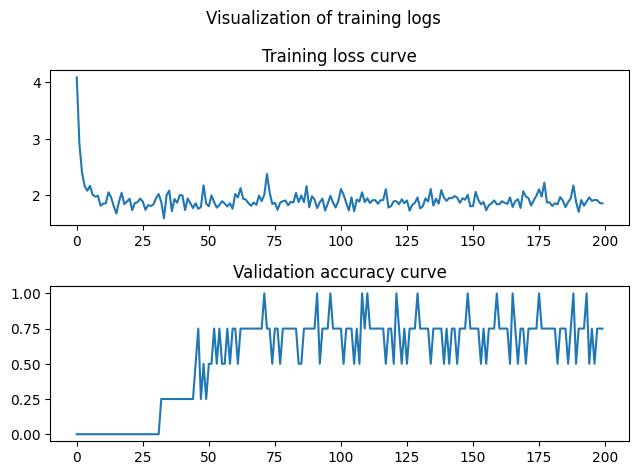

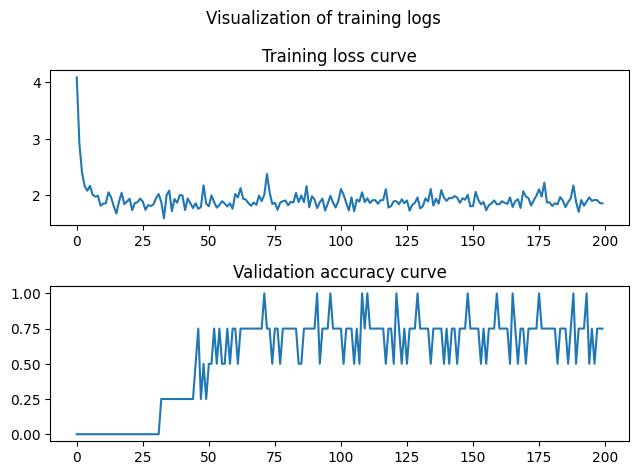

In [36]:
network.plot_log()

In [ ]:
network.train(trainDataLoader, testDataLoader)

Epoch:   0, loss_avg: 4.75056, val OA: 0.05024, best val OA: 0.05024
Epoch:   1, loss_avg: 4.76019, val OA: 0.04579, best val OA: 0.05024
Epoch:   2, loss_avg: 4.73498, val OA: 0.05186, best val OA: 0.05186
Epoch:   3, loss_avg: 4.75178, val OA: 0.04822, best val OA: 0.05186
Epoch:   4, loss_avg: 4.73723, val OA: 0.05024, best val OA: 0.05186
Epoch:   5, loss_avg: 4.76068, val OA: 0.04943, best val OA: 0.05186
Epoch:   6, loss_avg: 4.73893, val OA: 0.05105, best val OA: 0.05186
Epoch:   7, loss_avg: 4.72933, val OA: 0.04498, best val OA: 0.05186
Epoch:   8, loss_avg: 4.76802, val OA: 0.04781, best val OA: 0.05186
Epoch:   9, loss_avg: 4.75623, val OA: 0.04538, best val OA: 0.05186
Epoch:  10, loss_avg: 4.75731, val OA: 0.05308, best val OA: 0.05308
Epoch:  11, loss_avg: 4.74173, val OA: 0.04943, best val OA: 0.05308


KeyboardInterrupt: ignored

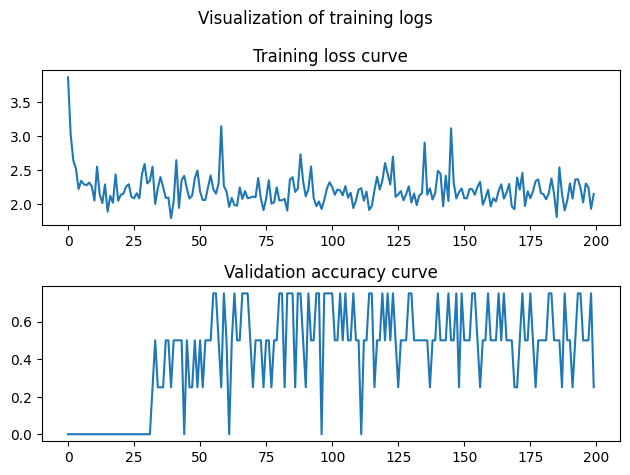

In [ ]:
fig = network.plot_log()
fig.savefig(os.path.join(model_dir,"training_logs.png"))

In [ ]:
from datetime import date
lines=["Used a single batch of size 4 for training and validation.",
       "\n"+str(config),
       str(date.today()),
       "Used label smoothing and log_softmax()",
       "Only k-nearest points with no similar points.",
       ]
with open(os.path.join(model_dir,'description.txt'), 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [ ]:
network._restore("/content/drive/MyDrive/cpsc_533y/modelnet40_experiments/so3_rot_8/single_batch_1/logs/best_model.pth",restore_training=True)

restoring /content/drive/MyDrive/cpsc_533y/modelnet40_experiments/so3_rot_8/single_batch_1/logs/best_model.pth


In [ ]:
config.noise_std=0.08
noisy_testDataset=ModelNetDataLoader(test_data,test_label,use_voxel=use_voxel,point_num=n_points,rot_type=rot_type,rot=rot,noise_std=config.noise_std)
noisy_testDataLoader=torch.utils.data.DataLoader(noisy_testDataset,batch_size=config.batch_size,shuffle=False)

In [ ]:
print(config.noise_std)
network.test(noisy_testDataLoader, mode="test")

0.08
restoring /content/drive/MyDrive/cpsc_533y/modelnet40_experiments/no_rot_8/full_train_1/logs/best_model.pth


tensor(0.0616, device='cuda:0')

In [ ]:
sum([x.nelement() for x in network.model.GSN.parameters()])

1055744

In [ ]:
sum([x.nelement() for x in network.model.GRN.parameters()])

4259235